In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

device = get_free_gpu()

current device cuda:15


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

In [4]:
print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
top_k_file = experiment_folder + "importance/bottleneck_topkinds_seed_{seed}.csv"
makedir(top_k_file)

random_seeds = range(1,4)


27 8 6


## Optimization

In [5]:
def get_model(random_seed):
    set_seed(random_seed)

    config = {
        "n_concepts": 4,
    }

    makedir(experiment_folder)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)

    model = models_original.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, device=device)
    model_path = model.get_model_path(experiment_folder, dataset="mimic", pruning="importance", seed=random_seed)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights, save_model_path=model_path, max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model(1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/mimic/original/importance/num_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt


AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


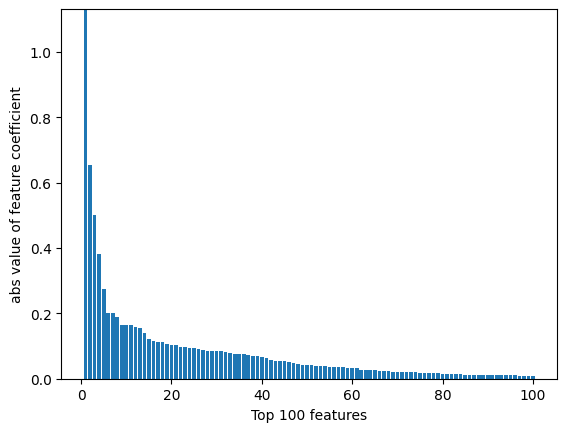

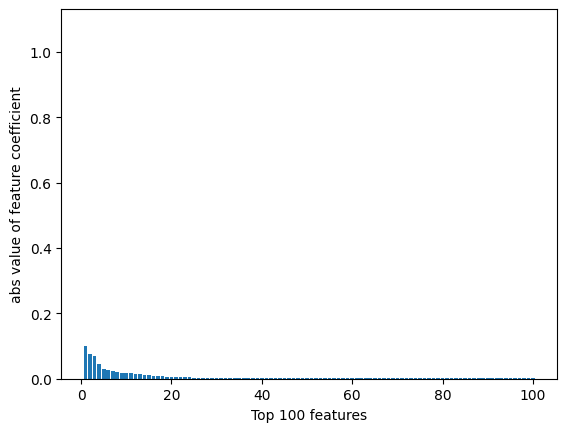

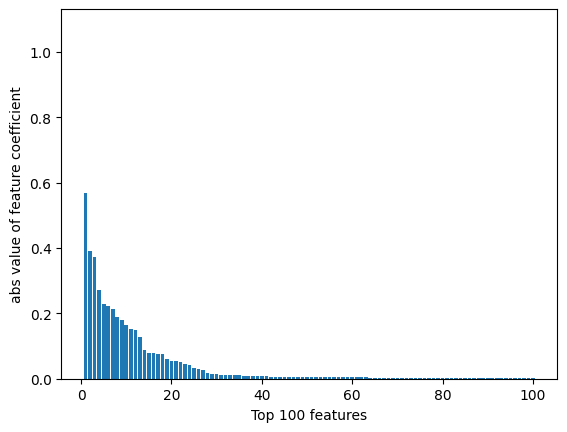

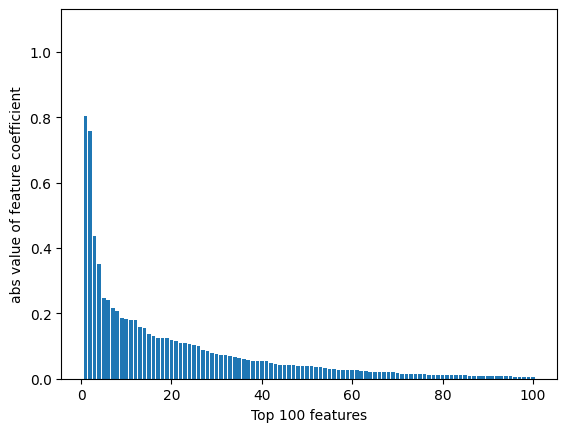

In [6]:
visualize_top100_weights_per_channel(model.bottleneck)


In [7]:
def plot_metrics(metric_list, x_labels):
    # Unzip the list of tuples into separate lists
    auc, acc, f1 = zip(*metric_list)
    
    # Plot each metric
    x = range(len(x_labels))
    plt.plot(x, auc, label='AUC')
    plt.plot(x, acc, label='ACC')
    plt.plot(x, f1, label='F1')
    
    plt.xticks(x, labels=x_labels)
    
    # Add labels and legend
    plt.xlabel('Percentages')
    plt.ylabel('Metric Value')
    plt.title('Pruning')
    plt.legend()
    
    # Show plot
    plt.show()
    
def get_list_from_mask(mask):
    selected_list = [[] for _ in range(mask.shape[0])]
    for i, row in enumerate(model.bottleneck.weight_mask):
        for j, value in enumerate(row):
            if value:
                selected_list[i].append(j)
    return selected_list

def plot_selected_weights(weight, selected_list, top_k=None, sorted=True, log_scale=True):
    abs_weight = weight.detach().cpu().numpy()
    abs_weight = np.abs(abs_weight)
    
    n_concepts = abs_weight.shape[0]
    max_y = np.max(abs_weight)
    
    fig, axs = plt.subplots(n_concepts, figsize=(8, 2 * n_concepts))
    
    for c in range(n_concepts):
        ax = axs[c]
        
        selected_list_idx = selected_list[c]
        if not selected_list_idx:
            continue
        
        min_weight = np.min(abs_weight[c][selected_list_idx])
        max_weight = np.max(abs_weight[c][selected_list_idx])
        
        if top_k is None:
            if sorted:
                weight_idx = np.argsort(-abs_weight[c])
            else:
                weight_idx = range(abs_weight.shape[1])
            
            weight_idx = weight_idx[abs_weight[c][weight_idx] >= min_weight]
        else:
            if sorted:
                weight_idx = np.argsort(-abs_weight[c])
            else:
                weight_idx = range(abs_weight.shape[1])
            
            top_k = min(top_k, abs_weight.shape[1])
            weight_idx = weight_idx[:top_k]
        
        n_rel_feat = len(weight_idx)
        
        def getColor(idx):
            if idx in selected_list_idx:
                return "red"
            else:
                return "gray"
        
        colors = [getColor(idx) for idx in weight_idx]
        ax.bar(np.arange(1, len(weight_idx)+1), abs_weight[c][weight_idx], color=colors)
        
        ax.set_title(f"Selected {len(selected_list_idx)}; of total {len(abs_weight[c])})")
        ax.set_xlabel(f"Top {n_rel_feat} features (descending by weight) (min={min_weight:.3f}) (max={max_weight:.3f})")
        ax.set_ylabel(f"Concept {c}")
        ax.set_ylim(0, max_y)
        if log_scale:
            ax.set_yscale('log')
        
        leg_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'blue', 'gray']]
        leg_labels = ["Selected", "Initialization", "Neither"]
        ax.legend(leg_handles, leg_labels)
    
    # plt.ylabel("abs value of feature coefficient")
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/mimic/original/importance/num_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
[656 587 519 450 382 313 245 176 108  40]


  2%|▏         | 2/100 [00:02<02:23,  1.46s/ epoch, Train Loss=0.48250, Val Loss=0.52344, Best Val Loss=0.52344]

 11%|█         | 11/100 [00:16<02:09,  1.46s/ epoch, Train Loss=0.48274, Val Loss=0.52453, Best Val Loss=0.52344]

Early Stopped


AUC macro 0.914
ACC macro 0.841
 F1 macro 0.848


 20%|██        | 20/100 [00:27<01:50,  1.38s/ epoch, Train Loss=0.48078, Val Loss=0.52518, Best Val Loss=0.52302]

Early Stopped


AUC macro 0.919
ACC macro 0.847
 F1 macro 0.854


 18%|█▊        | 18/100 [00:25<01:56,  1.42s/ epoch, Train Loss=0.47963, Val Loss=0.52387, Best Val Loss=0.52276]

Early Stopped


AUC macro 0.916
ACC macro 0.843
 F1 macro 0.850


 10%|█         | 10/100 [00:14<02:13,  1.48s/ epoch, Train Loss=0.47901, Val Loss=0.52431, Best Val Loss=0.52334]

Early Stopped


AUC macro 0.920
ACC macro 0.851
 F1 macro 0.857


 12%|█▏        | 12/100 [00:18<02:15,  1.54s/ epoch, Train Loss=0.47903, Val Loss=0.52991, Best Val Loss=0.52347]

Early Stopped


AUC macro 0.916
ACC macro 0.842
 F1 macro 0.849


 22%|██▏       | 22/100 [00:32<01:55,  1.48s/ epoch, Train Loss=0.48021, Val Loss=0.52420, Best Val Loss=0.52333]

Early Stopped


AUC macro 0.912
ACC macro 0.836
 F1 macro 0.844


 14%|█▍        | 14/100 [00:21<02:13,  1.55s/ epoch, Train Loss=0.47792, Val Loss=0.52770, Best Val Loss=0.52333]

Early Stopped


AUC macro 0.913
ACC macro 0.840
 F1 macro 0.847


 17%|█▋        | 17/100 [00:25<02:06,  1.52s/ epoch, Train Loss=0.47746, Val Loss=0.53010, Best Val Loss=0.52348]

Early Stopped


AUC macro 0.918
ACC macro 0.846
 F1 macro 0.852


 11%|█         | 11/100 [00:17<02:18,  1.55s/ epoch, Train Loss=0.47637, Val Loss=0.52631, Best Val Loss=0.52532]

Early Stopped


AUC macro 0.917
ACC macro 0.844
 F1 macro 0.851


 28%|██▊       | 28/100 [00:41<01:46,  1.48s/ epoch, Train Loss=0.47692, Val Loss=0.52992, Best Val Loss=0.52437]

Early Stopped


AUC macro 0.920
ACC macro 0.850
 F1 macro 0.856


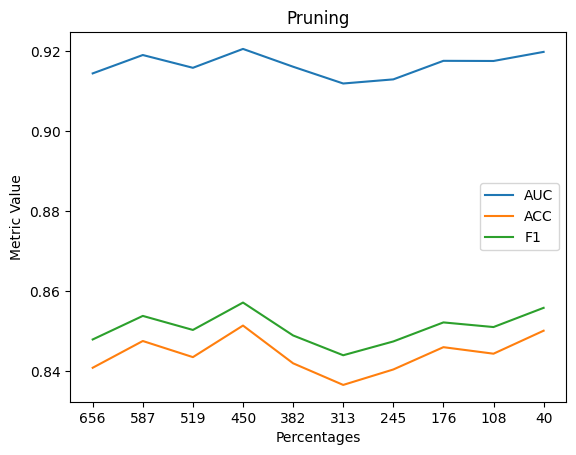

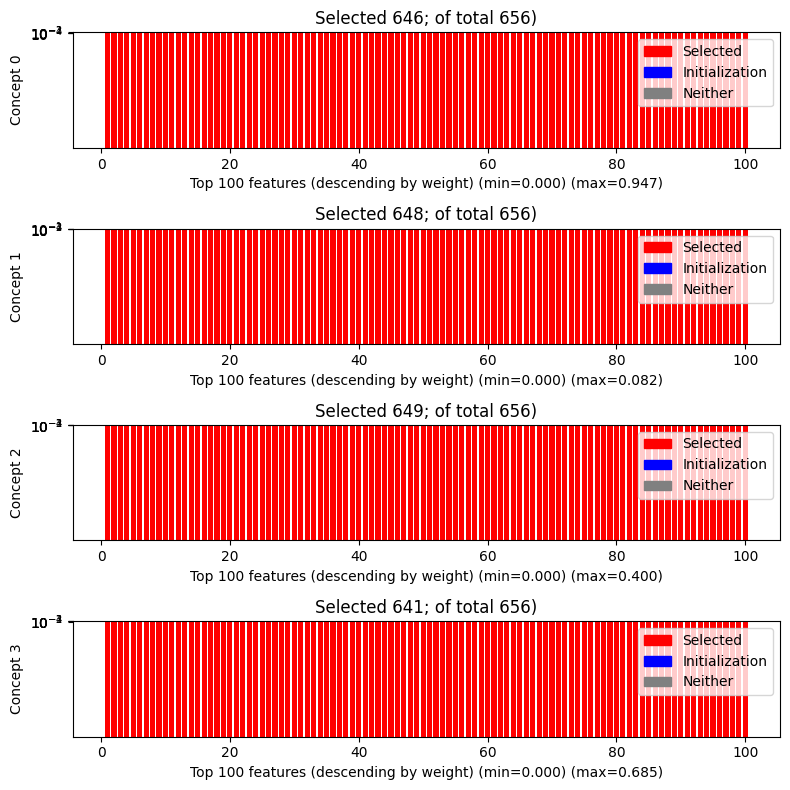

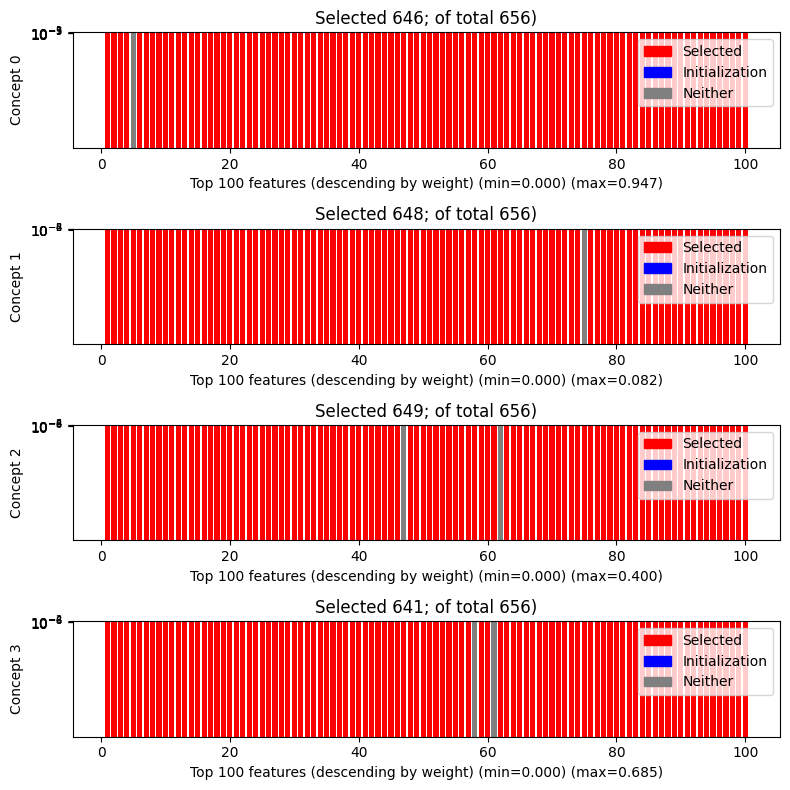

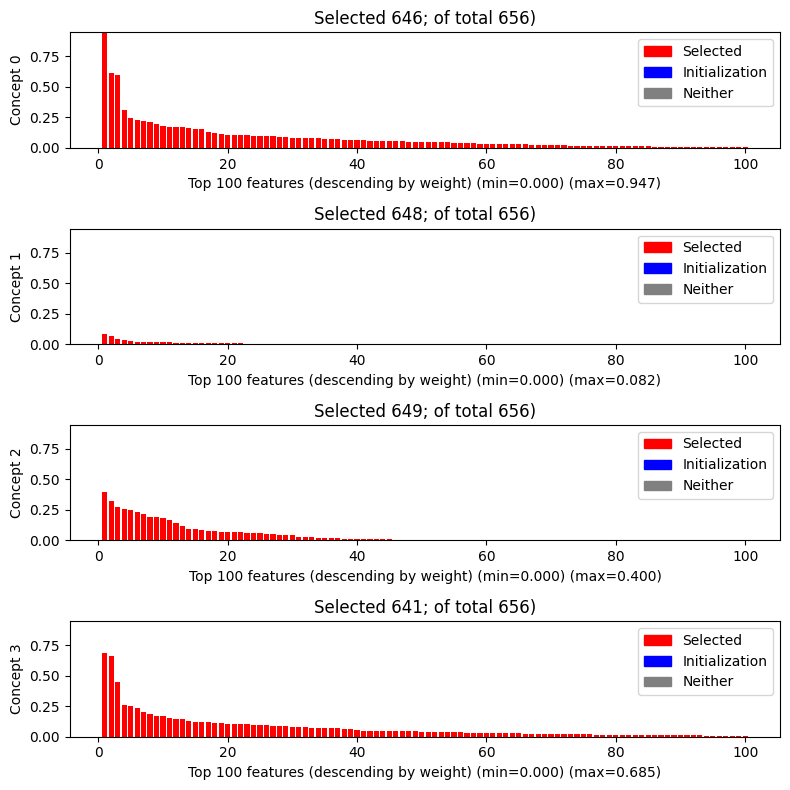

In [15]:
for random_seed in [1]:
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    metric_list = []
    max_weights = model.bottleneck.weight.shape[1]
    min_weights = 40
    # x_labels = list(range(30, 90, 30)) + list(range(90, 100, 2))
    x_labels = np.linspace(max_weights, min_weights, 10, dtype=int)
    print(x_labels)
    for perc in x_labels:
        model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
        model.mask_by_weight_magnitude(perc)
        model.clear_ema_gradient()
        metrics = evaluate_classification(model, val_loader)
        metric_list.append(metrics)

plot_metrics(metric_list, x_labels)
selected_list = get_list_from_mask(model.bottleneck.weight_mask)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, sorted=False)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, log_scale=False)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/mimic/original/importance/num_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


 11%|█         | 11/100 [00:17<02:19,  1.57s/ epoch, Train Loss=0.48274, Val Loss=0.52453, Best Val Loss=0.52344]

Early Stopped


AUC macro 0.914
ACC macro 0.839
 F1 macro 0.846


  4%|▍         | 4/100 [00:05<02:18,  1.45s/ epoch, Train Loss=0.48516, Val Loss=0.52622, Best Val Loss=0.52622]

 20%|██        | 20/100 [00:30<02:02,  1.54s/ epoch, Train Loss=0.48405, Val Loss=0.52679, Best Val Loss=0.52439]

Early Stopped


AUC macro 0.914
ACC macro 0.842
 F1 macro 0.848


 30%|███       | 30/100 [00:44<01:44,  1.50s/ epoch, Train Loss=0.48049, Val Loss=0.52755, Best Val Loss=0.52239]

Early Stopped


AUC macro 0.912
ACC macro 0.836
 F1 macro 0.844


 19%|█▉        | 19/100 [00:28<01:59,  1.48s/ epoch, Train Loss=0.48258, Val Loss=0.52664, Best Val Loss=0.52363]

Early Stopped


AUC macro 0.918
ACC macro 0.860
 F1 macro 0.864


 23%|██▎       | 23/100 [00:34<01:56,  1.51s/ epoch, Train Loss=0.47897, Val Loss=0.52640, Best Val Loss=0.52365]

Early Stopped


AUC macro 0.902
ACC macro 0.824
 F1 macro 0.833


 14%|█▍        | 14/100 [00:22<02:16,  1.58s/ epoch, Train Loss=0.47708, Val Loss=0.52574, Best Val Loss=0.52261]

Early Stopped


AUC macro 0.905
ACC macro 0.829
 F1 macro 0.837


 15%|█▌        | 15/100 [00:22<02:08,  1.51s/ epoch, Train Loss=0.47740, Val Loss=0.52316, Best Val Loss=0.52312]

Early Stopped


AUC macro 0.906
ACC macro 0.829
 F1 macro 0.838


 16%|█▌        | 16/100 [00:25<02:12,  1.58s/ epoch, Train Loss=0.47895, Val Loss=0.53668, Best Val Loss=0.52405]

Early Stopped


AUC macro 0.916
ACC macro 0.845
 F1 macro 0.852


 23%|██▎       | 23/100 [00:34<01:55,  1.50s/ epoch, Train Loss=0.47695, Val Loss=0.52677, Best Val Loss=0.52370]

Early Stopped


AUC macro 0.909
ACC macro 0.834
 F1 macro 0.841


 15%|█▌        | 15/100 [00:22<02:06,  1.49s/ epoch, Train Loss=0.47653, Val Loss=0.53039, Best Val Loss=0.52524]

Early Stopped


AUC macro 0.917
ACC macro 0.849
 F1 macro 0.855


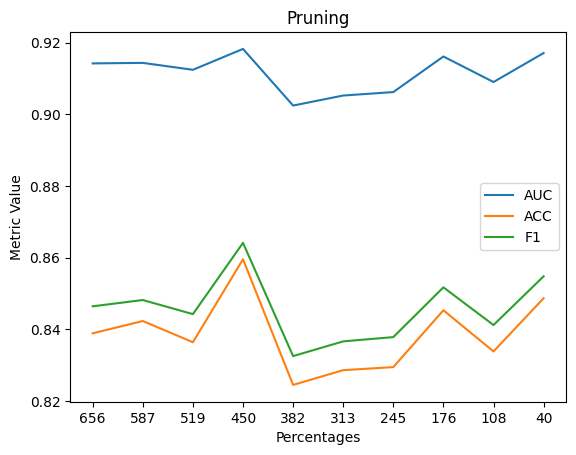

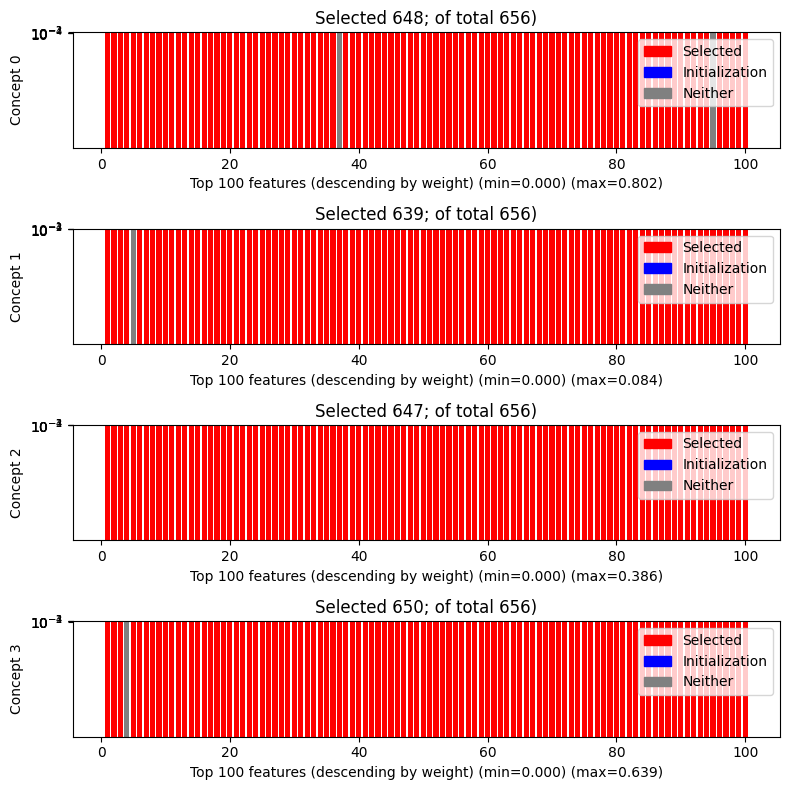

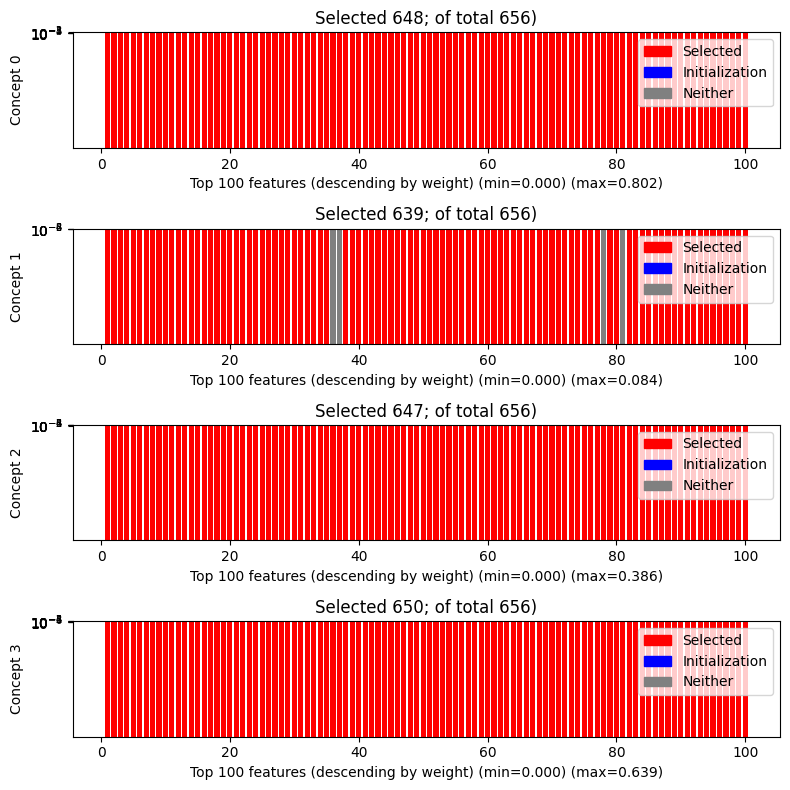

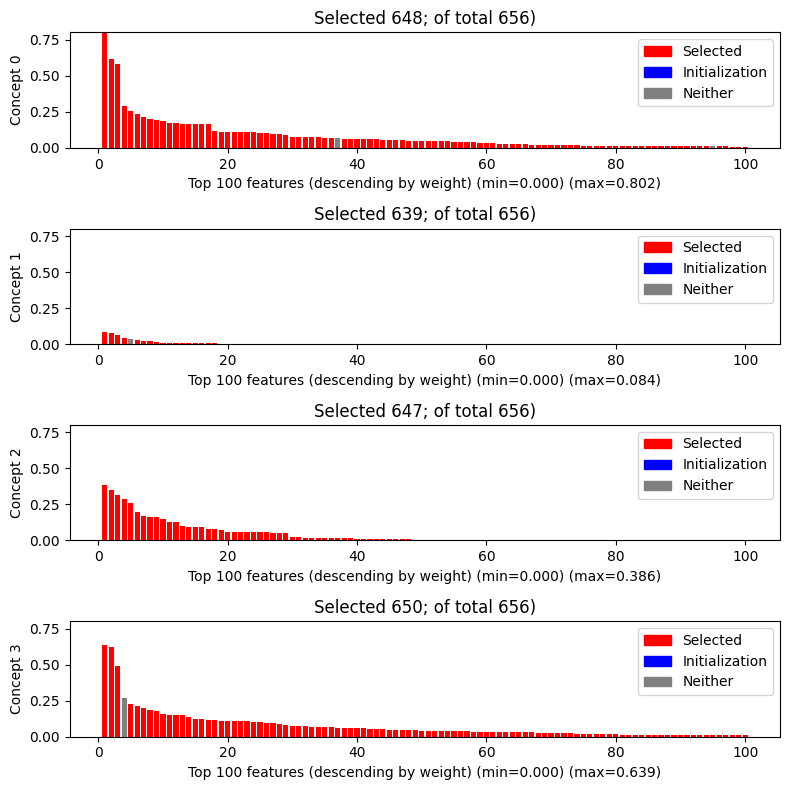

In [16]:
for random_seed in [1]:
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    metric_list = []
    max_weights = model.bottleneck.weight.shape[1]
    min_weights = 40
    # x_labels = list(range(30, 90, 30)) + list(range(90, 100, 2))
    x_labels = np.linspace(max_weights, min_weights, 10, dtype=int)
    for perc in x_labels:
        model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
        model.mask_by_gradient_magnitude(perc)
        model.clear_ema_gradient()
        metrics = evaluate_classification(model, val_loader)
        metric_list.append(metrics)

plot_metrics(metric_list, x_labels)
selected_list = get_list_from_mask(model.bottleneck.weight_mask)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, sorted=False)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, log_scale=False)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/mimic/original/importance/num_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


 11%|█         | 11/100 [00:17<02:20,  1.58s/ epoch, Train Loss=0.48274, Val Loss=0.52453, Best Val Loss=0.52344]

Early Stopped


AUC macro 0.896
ACC macro 0.858
 F1 macro 0.860
After pruning:  (0.8959610462188721, 0.8584420084953308, 0.8595505356788635)


 66%|██████▌   | 66/100 [01:34<00:49,  1.45s/ epoch, Train Loss=0.48668, Val Loss=0.52946, Best Val Loss=0.52786]

 68%|██████▊   | 68/100 [01:38<00:46,  1.45s/ epoch, Train Loss=0.48702, Val Loss=0.52909, Best Val Loss=0.52786]

Early Stopped


AUC macro 0.915
ACC macro 0.841
 F1 macro 0.848
After pruning and finetuning:  (0.9153875112533569, 0.8413692712783813, 0.8481563329696655)


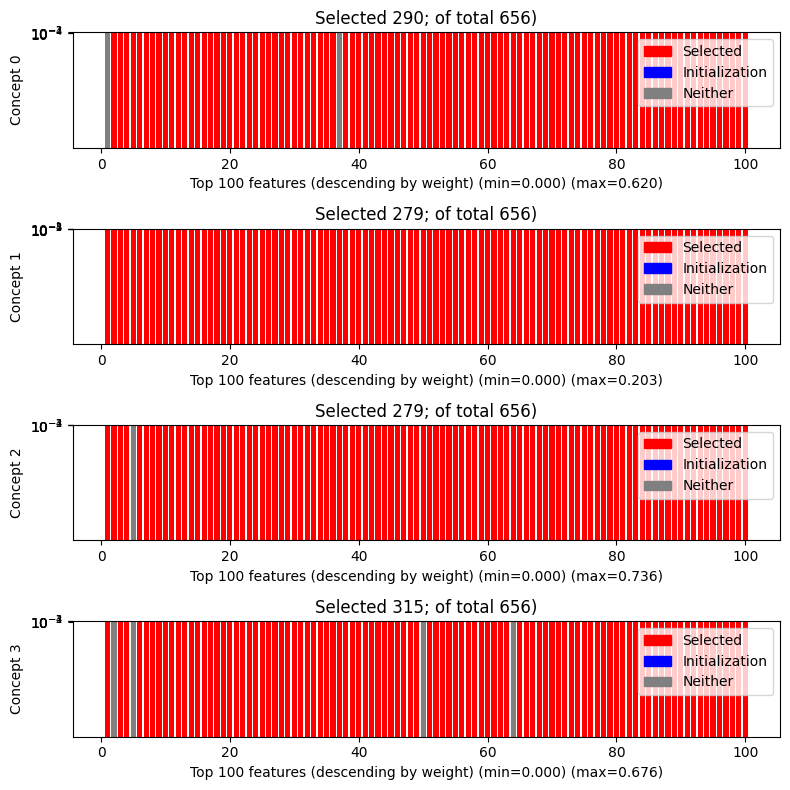

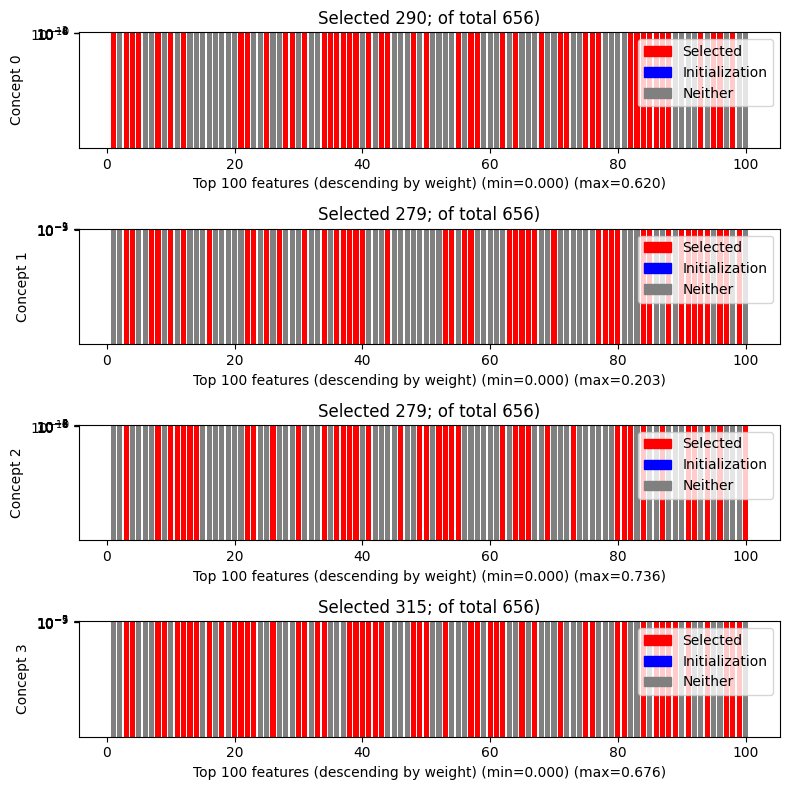

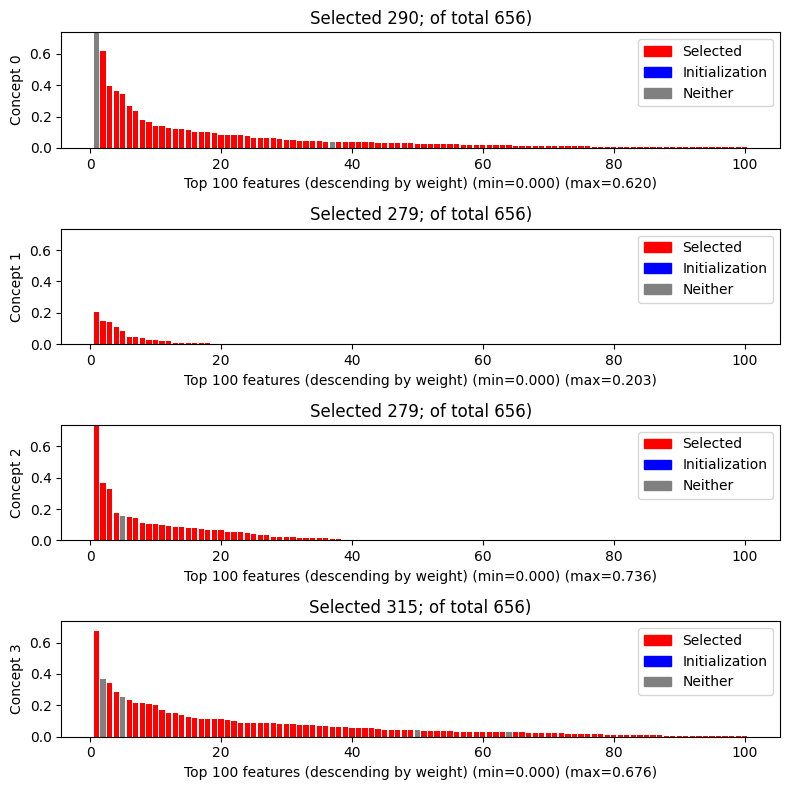

In [17]:
for random_seed in [1]:
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
    
    model.mask_shrinking_weights()
    metrics = evaluate_classification(model, val_loader)
    print("After pruning: ", metrics)
    
    model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
    metrics = evaluate_classification(model, val_loader)
    print("After pruning and finetuning: ", metrics)

selected_list = get_list_from_mask(model.bottleneck.weight_mask)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, sorted=False)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, log_scale=False)


In [6]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

results = []
for random_seed in random_seeds:
    print("random_seed", random_seed)
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    save_path = top_k_file.format(seed=random_seed)
    
    
    results.append(greedy_results)
    

random_seed 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
Found 4 Concepts
90th percentile per concept [8.141751  0.8794138 4.321822  7.642881 ]
['Concept 0 len: 79', 'Concept 1 len: 272', 'Concept 2 len: 77', 'Concept 3 len: 71']


100%|██████████| 40/40 [4:08:22<00:00, 372.57s/it, Score=0.91963, acc=0.858, f1=0.863, auc=0.92]   


random_seed 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_2.pt
AUC macro 0.921
ACC macro 0.844
 F1 macro 0.852
Found 4 Concepts
90th percentile per concept [ 0.28210557 10.270896    6.4929314   2.3336902 ]
['Concept 0 len: 299', 'Concept 1 len: 95', 'Concept 2 len: 105', 'Concept 3 len: 150']


100%|██████████| 40/40 [5:18:27<00:00, 477.68s/it, Score=0.92956, acc=0.842, f1=0.855, auc=0.93]   


random_seed 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_3.pt
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.845
Found 4 Concepts
90th percentile per concept [1.3721063  9.55452    0.41133872 7.4182534 ]
['Concept 0 len: 239', 'Concept 1 len: 81', 'Concept 2 len: 295', 'Concept 3 len: 72']


100%|██████████| 40/40 [5:24:46<00:00, 487.17s/it, Score=0.92909, acc=0.858, f1=0.865, auc=0.929]  


In [ ]:
random_seed = 1
model = get_model(random_seed)
top_k_inds = get_top_features_per_concept(model.bottleneck)
greedy_results = read_df_from_csv(top_k_file.format(seed=random_seed))

pd.set_option('display.max_rows', 100)

print(len(top_k_inds))
[print(x) for x in top_k_inds]
greedy_results


In [ ]:
plot_selected_weights(model.bottleneck.weight, top_k_inds, greedy_results, 100)

In [8]:
result_df = evaluate_greedy_selection(get_model, get_MIMIC_dataloader, top_k_file, n_experiments=3)
result_df.groupby(["Split", "Mask", "Finetuned"]).mean()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.914
ACC macro 0.839
 F1 macro 0.846
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.920
ACC macro 0.858
 F1 macro 0.863
AUC macro 0.916
ACC macro 0.858
 F1 macro 0.863
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/finetuned/n_concepts_4_seed_1.pt
AUC macro 0.909
ACC macro 0.837
 F1 macro 0.844
AUC macro 0.909
ACC macro 0.842
 F1 macro 0.848


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_2.pt
AUC macro 0.921
ACC macro 0.844
 F1 macro 0.852
AUC macro 0.923
ACC macro 0.848
 F1 macro 0.856
AUC macro 0.921
ACC macro 0.844
 F1 macro 0.852
AUC macro 0.930
ACC macro 0.842
 F1 macro 0.855
AUC macro 0.926
ACC macro 0.836
 F1 macro 0.850
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/finetuned/n_concepts_4_seed_2.pt
AUC macro 0.922
ACC macro 0.852
 F1 macro 0.859
AUC macro 0.917
ACC macro 0.848
 F1 macro 0.855


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_3.pt
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.920
ACC macro 0.843
 F1 macro 0.850
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.929
ACC macro 0.858
 F1 macro 0.865
AUC macro 0.923
ACC macro 0.855
 F1 macro 0.862
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/finetuned/n_concepts_4_seed_3.pt
AUC macro 0.924
ACC macro 0.852
 F1 macro 0.859
AUC macro 0.915
ACC macro 0.846
 F1 macro 0.853


Seed       AUC       ACC        F1
Split Mask   Finetuned                                    
test  Empty  False       2.0  0.916475  0.839654  0.847360
      Greedy False       2.0  0.921804  0.849551  0.858044
             True        2.0  0.913676  0.845146  0.852178
val   Empty  False       2.0  0.919034  0.843257  0.850629
      Greedy False       2.0  0.926095  0.852808  0.860713
             True        2.0  0.918211  0.847032  0.853861

In [ ]:
def aggregate_greedy_results(top_k_file):
    metrics = ["AUC", "ACC", "F1"]
    aggregated_metrics_df = read_df_from_csv(top_k_file.format(seed=1))
    aggregated_metrics_df = aggregated_metrics_df[[metrics]]

    seeds = range(2, 4)

    for random_seed in random_seeds:
        greedy_results = read_df_from_csv(top_k_file.format(seed=seed))
        greedy_results = greedy_results[[metrics]]
            
        aggregated_metrics_df += greedy_results

    aggregated_metrics_df /= (len(seeds)+1)

    return aggregated_metrics_df

aggregate_greedy_results(top_k_file)